In [1]:
import numpy as np
import matplotlib.pyplot as plt
import discretize
from discretize import TensorMesh
from discretize.utils import mkvc, refine_tree_xyz
import matplotlib as mpl
from SimPEG import utils, maps, regularization, optimization
from SimPEG.utils import plot2Ddata, model_builder, surface2ind_topo
from SimPEG.potential_fields import gravity
from scipy.interpolate import LinearNDInterpolator
########

In [2]:
[x_topo, y_topo] = np.meshgrid(np.linspace(-200, 200, 41), np.linspace(-200, 200, 41))
z_topo = 1000 * np.exp(-(x_topo ** 2 + y_topo ** 2) / 10 ** 2)
x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
topo_xyz = np.c_[x_topo, y_topo, z_topo]

# Define the observation locations as an (N, 3) numpy array or load them.
x = np.linspace(-80.0, 80.0, 17)
y = np.linspace(-80.0, 80.0, 17)
x, y = np.meshgrid(x, y)
x, y = mkvc(x.T), mkvc(y.T)
fun_interp = LinearNDInterpolator(np.c_[x_topo, y_topo], z_topo)
z = fun_interp(np.c_[x, y]) + 5.0
receiver_locations = np.c_[x, y, z]

# Define the component(s) of the field we want to simulate as strings within
# a list. Here we simulate only the vertical component of gravity anomaly.
components = ["gz"]

# Use the observation locations and components to define the receivers. To
# simulate data, the receivers must be defined as a list.
receiver_list = gravity.receivers.Point(receiver_locations, components=components)

receiver_list = [receiver_list]

# Defining the source field.
source_field = gravity.sources.SourceField(receiver_list=receiver_list)

# Defining the survey
survey = gravity.survey.Survey(source_field)
##########

In [3]:
#h = [10,10,10]
#mesh = TensorMesh(h)
#mesh.plot_grid()
##########

In [4]:
dh = 5.0
hx = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
hy = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
hz = [(dh, 5, -1.3), (dh, 15)]
#mesh = TensorMesh([hx, hy, hz], 'CCN')
mesh = TensorMesh([40, 40, 15])

In [5]:
#mesh.plot_grid()

In [6]:
# Define density contrast values for each unit in g/cc
background_density = 0.0
block_density = 2.3
sphere_density = 0.2

# Find the indices for the active mesh cells (e.g. cells below surface)
ind_active = surface2ind_topo(mesh, topo_xyz)

# Define mapping from model to active cells. The model consists of a value for
# each cell below the Earth's surface.
nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=nC)

# Define model. Models in SimPEG are vector arrays.
model = background_density * np.ones(nC)

/Users/adeniyim/miniforge3/envs/deeplearning/lib/python3.8/site-packages/discretize/utils/code_utils.py:182: FutureWarning: TensorMesh.vectorNx has been deprecated, please use TensorMesh.nodes_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/Users/adeniyim/miniforge3/envs/deeplearning/lib/python3.8/site-packages/discretize/utils/code_utils.py:182: FutureWarning: TensorMesh.vectorNy has been deprecated, please use TensorMesh.nodes_y. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/Users/adeniyim/miniforge3/envs/deeplearning/lib/python3.8/site-packages/discretize/utils/code_utils.py:182: FutureWarning: TensorMesh.vectorCCx has been deprecated, please use TensorMesh.cell_centers_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/Users/adeniyim/miniforge3/envs/deeplearning/lib/python3.8/site-packages/discretize/utils/code_utils.py:182: FutureWarning: TensorMesh.vectorCCy has 

In [7]:
ind_active

array([ True,  True,  True, ...,  True,  True,  True])

In [8]:
set(ind_active)

{True}

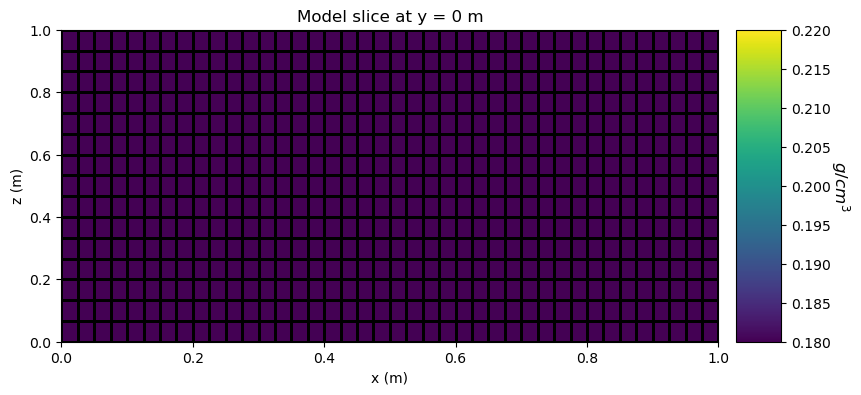

In [10]:
# You could find the indicies of specific cells within the model and change their
# value to add structures.
'''
ind_block = (
    (mesh.gridCC[ind_active, 0] > -50.0)
    & (mesh.gridCC[ind_active, 0] < -20.0)
    & (mesh.gridCC[ind_active, 1] > -15.0)
    & (mesh.gridCC[ind_active, 1] < 15.0)
    & (mesh.gridCC[ind_active, 2] > -50.0)
    & (mesh.gridCC[ind_active, 2] < -30.0)
)
model[ind_block] = block_density


ind_block = (
    (mesh.gridCC[ind_active, 0] > 0.2)
    & (mesh.gridCC[ind_active, 0] < 0.1)
    & (mesh.gridCC[ind_active, 1] > 0.15)
    & (mesh.gridCC[ind_active, 1] < 0.15)
    & (mesh.gridCC[ind_active, 2] > 0.50)
    & (mesh.gridCC[ind_active, 2] < 0.30)
)

model[ind_block] = block_density
'''
# You can also use SimPEG utilities to add structures to the model more concisely

ind_sphere = model_builder.getIndicesSphere(np.r_[0.20, 0.10, 0.40], 15.0, mesh.gridCC)
ind_sphere = ind_sphere[ind_active]
model[ind_sphere] = sphere_density

#ind_sphere = model_builder.getIndicesSphere(np.r_[35.0, 0.0, -40.0], 15.0, mesh.gridCC)
#ind_sphere = ind_sphere[ind_active]
#model[ind_sphere] = sphere_density

# Plot Density Contrast Model
fig = plt.figure(figsize=(9, 4))
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
mesh.plotSlice(
    plotting_map * model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.nCy / 2),
    grid=True,
    clim=(np.min(model), np.max(model)),
    pcolorOpts={"cmap": "viridis"},
)
ax1.set_title("Model slice at y = 0 m")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.78])
norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=12)

plt.show()

/Users/adeniyim/miniforge3/envs/deeplearning/lib/python3.8/site-packages/discretize/base/base_tensor_mesh.py:1025: FutureWarning: hx has been deprecated, please access as mesh.h[0]
  warnings.warn(
/Users/adeniyim/miniforge3/envs/deeplearning/lib/python3.8/site-packages/discretize/base/base_tensor_mesh.py:1042: FutureWarning: hy has been deprecated, please access as mesh.h[1]
  warnings.warn(
/Users/adeniyim/miniforge3/envs/deeplearning/lib/python3.8/site-packages/discretize/base/base_tensor_mesh.py:1059: FutureWarning: hz has been deprecated, please access as mesh.h[2]
  warnings.warn(


ValueError: Contour levels must be increasing

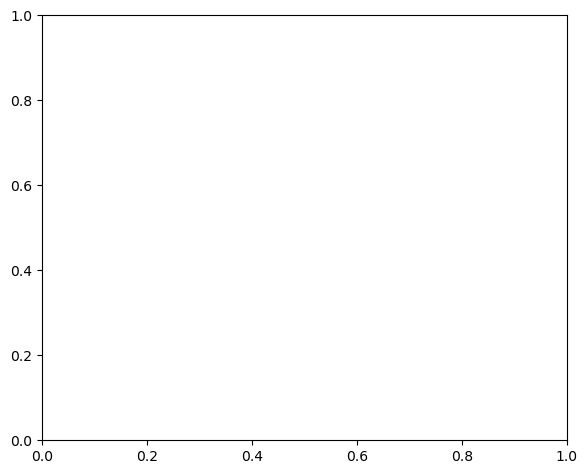

In [10]:
simulation = gravity.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=mesh,
    rhoMap=model_map,
    actInd=ind_active,
    store_sensitivities="forward_only",
)

# Compute predicted data for some model
# SimPEG uses right handed coordinate where Z is positive upward.
# This causes gravity signals look "inconsistent" with density values in visualization.
dpred = simulation.dpred(model)

# Plot
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])
plot2Ddata(receiver_list[0].locations, dpred, ax=ax1, contourOpts={"cmap": "bwr"})
ax1.set_title("Gravity Anomaly (Z-component)")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.82, 0.1, 0.03, 0.85])
norm = mpl.colors.Normalize(vmin=-np.max(np.abs(dpred)), vmax=np.max(np.abs(dpred)))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr, format="%.1e"
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

In [ ]:
fname = "gravity_topo.txt"
np.savetxt(fname, np.c_[topo_xyz], fmt="%.4e")

np.random.seed(737)
maximum_anomaly = np.max(np.abs(dpred))
noise = 0.01 * maximum_anomaly * np.random.rand(len(dpred))
fname = "gravity_data.obs"
np.savetxt(fname, np.c_[receiver_locations, dpred + noise], fmt="%.4e")

In [ ]:
# Load topography
fname = "gravity_topo.txt"
xyz_topo = np.loadtxt(str(fname))

fname_ = "gravity_data.obs"
# Load field data
dobs = np.loadtxt(str(fname_))

# Define receiver locations and observed data
receiver_locations = dobs[:, 0:3]
dobs = dobs[:, -1]

In [ ]:
# Plot
mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(receiver_locations, dobs, ax=ax1, contourOpts={"cmap": "bwr"})
ax1.set_title("Gravity Anomaly")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.8, 0.1, 0.03, 0.85])
norm = mpl.colors.Normalize(vmin=-np.max(np.abs(dobs)), vmax=np.max(np.abs(dobs)))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr, format="%.1e"
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

In [11]:
maximum_anomaly = np.max(np.abs(dobs))

uncertainties = 0.01 * maximum_anomaly * np.ones(np.shape(dobs))

NameError: name 'dobs' is not defined

In [12]:
# Define the receivers. The data consist of vertical gravity anomaly measurements.
# The set of receivers must be defined as a list.
receiver_list = gravity.receivers.Point(receiver_locations, components="gz")

receiver_list = [receiver_list]

# Define the source field
source_field = gravity.sources.SourceField(receiver_list=receiver_list)

# Define the survey
survey = gravity.survey.Survey(source_field)

In [13]:
from SimPEG import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

In [27]:
data_object = data.Data(survey, dobs=dobs, standard_deviation=uncertainties)

In [28]:
# Define density contrast values for each unit in g/cc. Don't make this 0!
# Otherwise the gradient for the 1st iteration is zero and the inversion will
# not converge.
background_density = 1e-6

# Find the indecies of the active cells in forward model (ones below surface)
ind_active = surface2ind_topo(mesh, xyz_topo)

# Define mapping from model to active cells
nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=nC)  # model consists of a value for each active cell

# Define and plot starting model
starting_model = background_density * np.ones(nC)

In [29]:
simulation = gravity.simulation.Simulation3DIntegral(
    survey=survey, mesh=mesh, rhoMap=model_map, actInd=ind_active
)

In [30]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis = data_misfit.L2DataMisfit(data=data_object, simulation=simulation)
dmis.W = utils.sdiag(1 / uncertainties)

# Define the regularization (model objective function).
reg = regularization.Sparse(mesh, indActive=ind_active, mapping=model_map)
reg.norms = np.c_[0, 2, 2, 2]

# Define how the optimization problem is solved. Here we will use a projected
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.ProjectedGNCG(
    maxIter=100, lower=-1.0, upper=1.0, maxIterLS=20, maxIterCG=10, tolCG=1e-3
)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

In [31]:
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e0)

# Defines the directives for the IRLS regularization. This includes setting
# the cooling schedule for the trade-off parameter.
update_IRLS = directives.Update_IRLS(
    f_min_change=1e-4,
    max_irls_iterations=30,
    coolEpsFact=1.5,
    beta_tol=1e-2,
)

# Defining the fractional decrease in beta and the number of Gauss-Newton solves
# for each beta value.
beta_schedule = directives.BetaSchedule(coolingFactor=5, coolingRate=1)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Updating the preconditionner if it is model dependent.
update_jacobi = directives.UpdatePreconditioner()

# Add sensitivity weights
sensitivity_weights = directives.UpdateSensitivityWeights(everyIter=False)

# The directives are defined as a list.
directives_list = [
    update_IRLS,
    sensitivity_weights,
    starting_beta,
    beta_schedule,
    save_iteration,
    update_jacobi,
]

In [32]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run inversion
recovered_model = inv.run(starting_model)

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***


/Users/adeniyim/miniforge3/envs/deeplearning/lib/python3.8/site-packages/discretize/utils/code_utils.py:182: FutureWarning: TensorMesh._cellGradxStencil has been deprecated, please use TensorMesh.stencil_cell_gradient_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/Users/adeniyim/miniforge3/envs/deeplearning/lib/python3.8/site-packages/discretize/utils/code_utils.py:182: FutureWarning: TensorMesh._cellGradyStencil has been deprecated, please use TensorMesh.stencil_cell_gradient_y. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/Users/adeniyim/miniforge3/envs/deeplearning/lib/python3.8/site-packages/discretize/utils/code_utils.py:182: FutureWarning: TensorMesh._cellGradzStencil has been deprecated, please use TensorMesh.stencil_cell_gradient_z. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.10e+07  5.95e+04  0.00e+00  5.95e+04    1.55e+02      0              
   1  6.10e+06  5.00e+02  7.66e-05  9.67e+02    1.53e+02      0              
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 0.014582001426495196 eps_q: 0.014582001426495196
   2  6.10e+05  6.52e+01  9.22e-05  1.21e+02    1.53e+02      0   Skip BFGS  
   3  2.99e+05  4.97e+01  1.19e-04  8.52e+01    2.80e+01      0   Skip BFGS  
   4  1.69e+05  3.97e+01  1.46e-04  6.44e+01    2.05e+01      0              
   5  1.03e+05  3.51e+01  1.48e-04  5.04e+01    2.04e+01      0   Skip BFGS  
   6  6.36e+04  3.47e+01  1.07e-04  4.15e+01    1.13e+01      0   Skip BFGS  
   7  3.92e+04  3.47e+01  6.84e-05  3.74e+01    4.

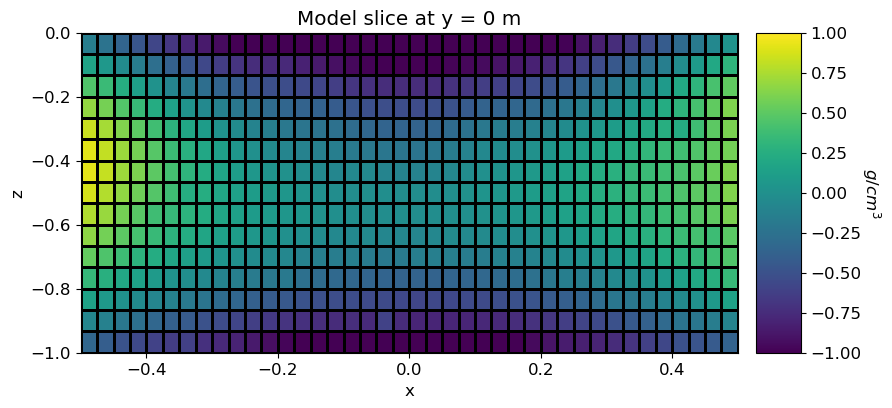

In [67]:
# Plot Recovered Model
fig = plt.figure(figsize=(9, 4))
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])
mesh.plotSlice(
    plotting_map * recovered_model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.nCy / 2),
    grid=True,
    clim=(np.min(recovered_model), np.max(recovered_model)),
    pcolorOpts={"cmap": "viridis"},
)
ax1.set_title("Model slice at y = 0 m")

ax2 = fig.add_axes([0.85, 0.1, 0.05, 0.8])
norm = mpl.colors.Normalize(vmin=np.min(recovered_model), vmax=np.max(recovered_model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=12)

plt.show()

-------------

In [ ]:
import discretize
from pymatsolver import SolverLU
import numpy as np
import matplotlib.pyplot as plt


def run(plotIt=True):

    # Step1: Generate Tensor and Curvilinear Mesh
    sz = [40, 40]
    tM = discretize.TensorMesh(sz)
    rM = discretize.CurvilinearMesh(discretize.utils.exampleLrmGrid(sz, "rotate"))

    # Step2: Direct Current (DC) operator
    def DCfun(mesh, pts):
        D = mesh.face_divergence
        sigma = 1e-2 * np.ones(mesh.nC)
        #print(sigma.shape)
        #print(np.unique(sigma))
        MsigI = mesh.getFaceInnerProduct(sigma, invProp=True, invMat=True)
        A = -D * MsigI * D.T
        A[-1, -1] /= mesh.vol[-1]  # Remove null space
        rhs = np.zeros(mesh.nC)
        txind = discretize.utils.closestPoints(mesh, pts)
        rhs[txind] = np.r_[1, -1]
        print(rhs.shape)
        return A, rhs

    pts = np.vstack((np.r_[0.25, 0.5], np.r_[0.75, 0.5]))

    # Step3: Solve DC problem (LU solver)
    AtM, rhstM = DCfun(tM, pts)
    #AinvtM = SolverLU(AtM)
    #phitM = AinvtM * rhstM

    #ArM, rhsrM = DCfun(rM, pts)

In [ ]:
run()

In [ ]:
pts = np.vstack((np.r_[0.25, 0.5], np.r_[0.75, 0.5]))

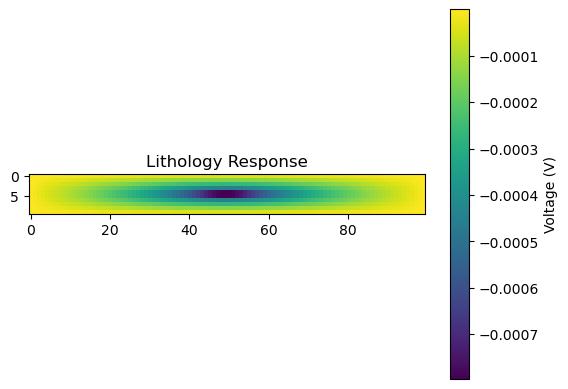

In [11]:
import discretize
from pymatsolver import SolverLU
import numpy as np
import matplotlib.pyplot as plt


def geophysics_data(points_of_interest, resolution):

    # Step1: Generate Tensor and Curvilinear Mesh
    resolution = [100, 10]
    xo = 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55
    yo = 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55
    ne = []
    for i in xo:
        for j in yo:
            k = np.r_[i, j]
            ne.append(k)
    points_of_interest = np.vstack(tuple(ne))
    
    # Step2: Direct Current (DC) operator
    grid = discretize.TensorMesh(resolution)
    direct = grid.face_divergence
    sigma = 1e-2 * np.ones(grid.nC)
    MsigI = grid.get_face_inner_product(sigma, invert_model=True, invert_matrix=True)
    A = -direct * MsigI * direct.T
    A[-1, -1] /= grid.cell_volumes[-1]
    rhs = np.zeros(grid.nC)
    txind = discretize.utils.closest_points_index(grid, points_of_interest)
    rhs[txind] = np.r_[1]

    # Step3: Solve DC problem (LU solver)
    AinvtM = SolverLU(A)
    phitM = AinvtM * rhs
    
    # plot type 1
    final = np.reshape(np.array(phitM), (10, 100)) #always remember, re
    fig, ax = plt.subplots(1)
    im = ax.imshow(final, cmap='viridis')
    cb = plt.colorbar(im)
    cb.set_label("Voltage (V)") #
    #ax.text(5, 5, 'your legend', bbox={'facecolor': 'white', 'pad': 2})
    plt.title("Lithology Response")
    plt.show()

    '''
    # plot type 2
    fig = plt.figure(figsize=(4., 4.))
    vmin, vmax = phitM.min(), phitM.max()
    dat = grid.plotImage(phitM, clim=(vmin, vmax), grid=False)
    cb0 = plt.colorbar(dat[0])
    cb0.set_label("Voltage (V)")
    plt.title("TensorMesh")
    '''

if __name__ == "__main__":
    geophysics_data(1,1)

(10000,)


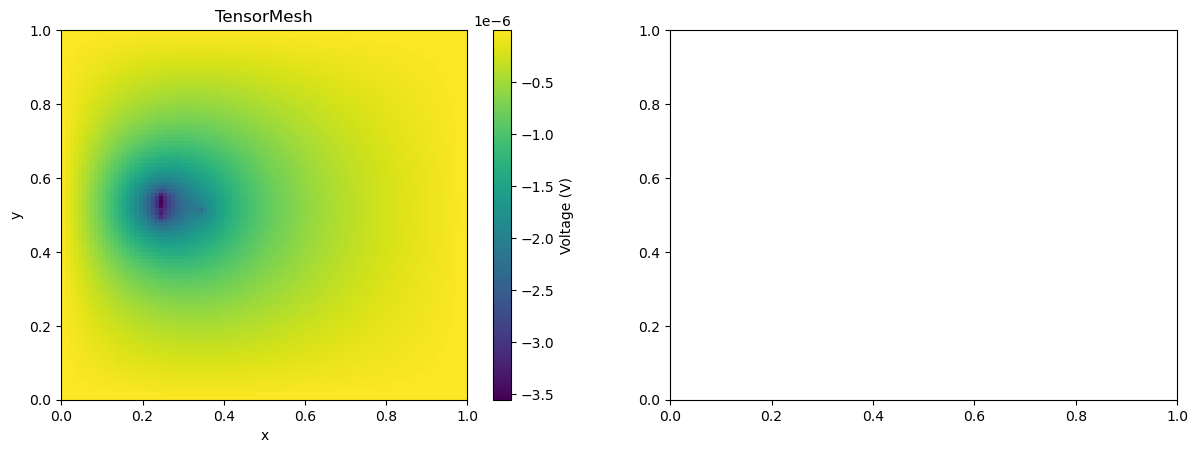

In [12]:
import discretize
from pymatsolver import SolverLU
import numpy as np
import matplotlib.pyplot as plt


def run(plotIt=True):

    # Step1: Generate Tensor and Curvilinear Mesh
    sz = [100, 100]
    tM = discretize.TensorMesh(sz)
    rM = discretize.CurvilinearMesh(discretize.utils.exampleLrmGrid(sz, "rotate"))

    # Step2: Direct Current (DC) operator
    def DCfun(mesh, pts):
        D = mesh.faceDiv
        sigma = 1e-2 * np.ones(mesh.nC)
        MsigI = mesh.getFaceInnerProduct(sigma, invProp=True, invMat=True)
        A = -D * MsigI * D.T
        A[-1, -1] /= mesh.vol[-1]  # Remove null space
        rhs = np.zeros(mesh.nC)
        txind = discretize.utils.closestPoints(mesh, pts)
        rhs[txind] = np.r_[1]
        return A, rhs

    pts = np.vstack((np.r_[0.25, 0.5], np.r_[0.25, 0.51], np.r_[0.35, 0.52], np.r_[0.25, 0.53], np.r_[0.25, 0.54], np.r_[0.25, 0.55], np.r_[0.25, 0.56])) # np.vstack((np.r_[0.25, 0.5], np.r_[0.75, 0.5]))

    # Step3: Solve DC problem (LU solver)
    AtM, rhstM = DCfun(tM, pts)
    AinvtM = SolverLU(AtM)
    phitM = AinvtM * rhstM
    print(phitM.shape)

    ArM, rhsrM = DCfun(rM, pts)
    AinvrM = SolverLU(ArM)
    phirM = AinvrM * rhsrM

    #if not plotIt:
        #return
    '''    
    final = np.reshape(np.array(phirM), (100, 100))
    im = plt.imshow(final, cmap='viridis')
    plt.colorbar(im)
    plt.show()
    '''

    # Step4: Making Figure
    fig, axes = plt.subplots(1, 2, figsize=(12 * 1.2, 4 * 1.2))
    vmin, vmax = phitM.min(), phitM.max()
    

    dat = tM.plotImage(phitM, ax=axes[0], clim=(vmin, vmax), grid=True)
    cb0 = plt.colorbar(dat[0], ax=axes[0])
    cb0.set_label("Voltage (V)")
    axes[0].set_title("TensorMesh")
'''
    dat = rM.plotImage(phirM, ax=axes[1], clim=(vmin, vmax), grid=True)
    cb1 = plt.colorbar(dat[0], ax=axes[1])
    cb1.set_label("Voltage (V)")
    axes[1].set_title("CurvilinearMesh")

'''
if __name__ == "__main__":
    run()
    plt.show()

------------------

### Function for Gravity - Geophysical measurement as constraints using GEMPY 

In [29]:
import gravity as v

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [30]:
np.random.seed(58)
station_indices = np.random.randint(0, high=900, size=15)

In [31]:
station_indices

array([803, 544, 791,  25, 756, 161,  90,  37, 768, 230, 628, 106, 252,
       640, 259])

In [32]:
station_coordinates = data_frame[['X', 'Y', 'Z']].values[station_indices, :]

In [33]:
station_coordinates

array([[  0.07475882,   3.52622591, -15.27905372],
       [  0.07475882,   2.98755794,  -7.09889902],
       [  0.07475882,   3.34666992,   2.27835149],
       [  0.07475882,   2.08977799, -10.88970242],
       [  0.07475882,   3.34666992,  -4.7047074 ],
       [  0.07475882,   2.26933398,  -3.70712756],
       [  0.07475882,   2.08977799,   2.07883553],
       [  0.07475882,   2.08977799,  -8.4955108 ],
       [  0.07475882,   3.34666992,  -2.31051578],
       [  0.07475882,   2.44888997,  -9.89212258],
       [  0.07475882,   3.16711393, -10.29115451],
       [  0.07475882,   2.26933398, -14.68050582],
       [  0.07475882,   2.44888997,  -5.50277127],
       [  0.07475882,   3.16711393,  -7.89696289],
       [  0.07475882,   2.44888997,  -4.10615949]])

In [34]:
c = v.CenteredGrid()

In [35]:
g = v.GravityPreprocessing(c)

In [36]:
g.set_centered_grid(station_coordinates, resolution = [10, 10, 40], radius=200)

In [37]:
g.kernel_centers
#g.kernel_dxyz_left
#g.kernel_dxyz_right

array([[-200.        , -200.        ,  -12.        ],
       [-200.        , -200.        ,  -14.4       ],
       [-200.        , -200.        ,  -14.7008054 ],
       ...,
       [ 200.        ,  200.        , -201.51654884],
       [ 200.        ,  200.        , -225.26971591],
       [ 200.        ,  200.        , -252.        ]])

In [38]:
g.kernel_centers.shape

(4961, 3)

In [39]:
tz = g.set_tz_kernel(resolution=[10, 10, 40], radius=200)
len(tz)

4961

In [40]:
tz.shape[0]

4961

In [41]:
a, b, c = g.kernel_centers, g.kernel_dxyz_left, g.kernel_dxyz_right
#kernel_centers, kernel_dxyz_left, kernel_dxyz_right = g.create_irregular_grid_kernel(resolution=[10, 10, 15], radius=6000)
#a, b, c = kernel_centers, kernel_dxyz_left, kernel_dxyz_right

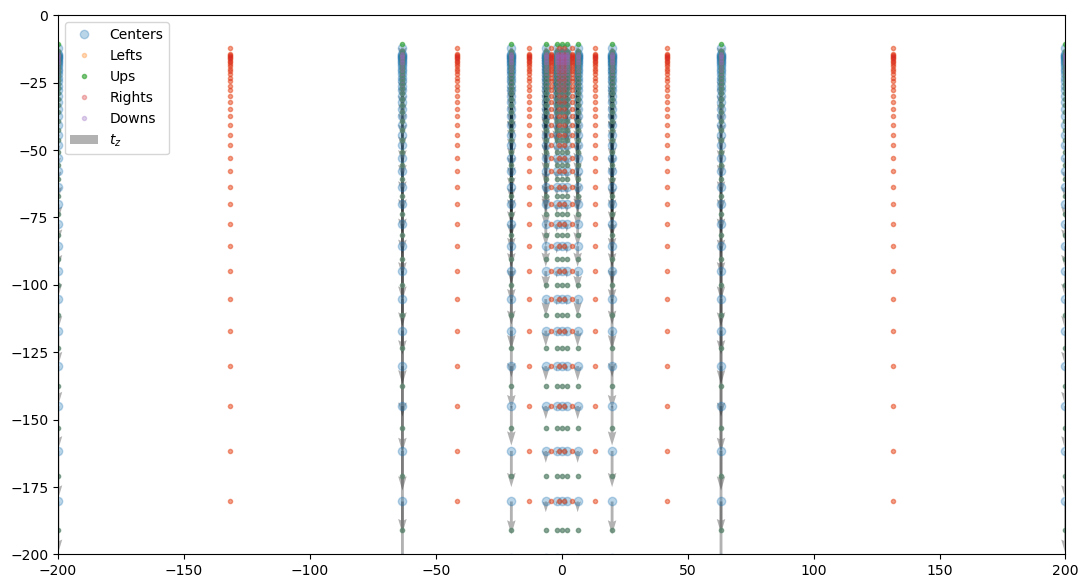

In [42]:
#list(np.array([1,2,3]) + [1])

fig = plt.figure(figsize=(13, 7))
plt.quiver(a[:, 0].reshape(11, 11, 41)[5, :, :].ravel(),
           a[:, 2].reshape(11, 11, 41)[:, 5, :].ravel(),
           np.zeros(451),
           tz.reshape(11, 11, 41)[5, :, :].ravel(), label='$t_z$', alpha=.3
           )

plt.plot(a[:, 0].reshape(11, 11, 41)[5, :, :].ravel(),
         a[:, 2].reshape(11, 11, 41)[:, 5, :].ravel(), 'o', alpha=.3, label='Centers')

plt.plot(a[:, 0].reshape(11, 11, 41)[5, :, :].ravel() - b[:, 0].reshape(11, 11, 41)[5, :, :].ravel(),
         a[:, 2].reshape(11, 11, 41)[:, 5, :].ravel(), '.', alpha=.3, label='Lefts')

plt.plot(a[:, 0].reshape(11, 11, 41)[5, :, :].ravel(),
         a[:, 2].reshape(11, 11, 41)[:, 5, :].ravel() - b[:, 2].reshape(11, 11, 41)[:, 5, :].ravel(), '.', alpha=.6,
         label='Ups')

plt.plot(a[:, 0].reshape(11, 11, 41)[5, :, :].ravel() + c[:, 0].reshape(11, 11, 41)[5, :, :].ravel(),
         a[:, 2].reshape(11, 11, 41)[:, 5, :].ravel(), '.', alpha=.3, label='Rights')

plt.plot(a[:, 0].reshape(11, 11, 41)[5, :, :].ravel(),
         a[:, 2].reshape(11, 11, 41)[:, 5, :].ravel() + c[:, 2].reshape(11, 11, 41)[5, :, :].ravel(), '.', alpha=.3,
         label='Downs')

plt.xlim(-200, 200)
plt.ylim(-200, 0)
plt.legend()
plt.show()

# %%
# Just the quiver:
# 

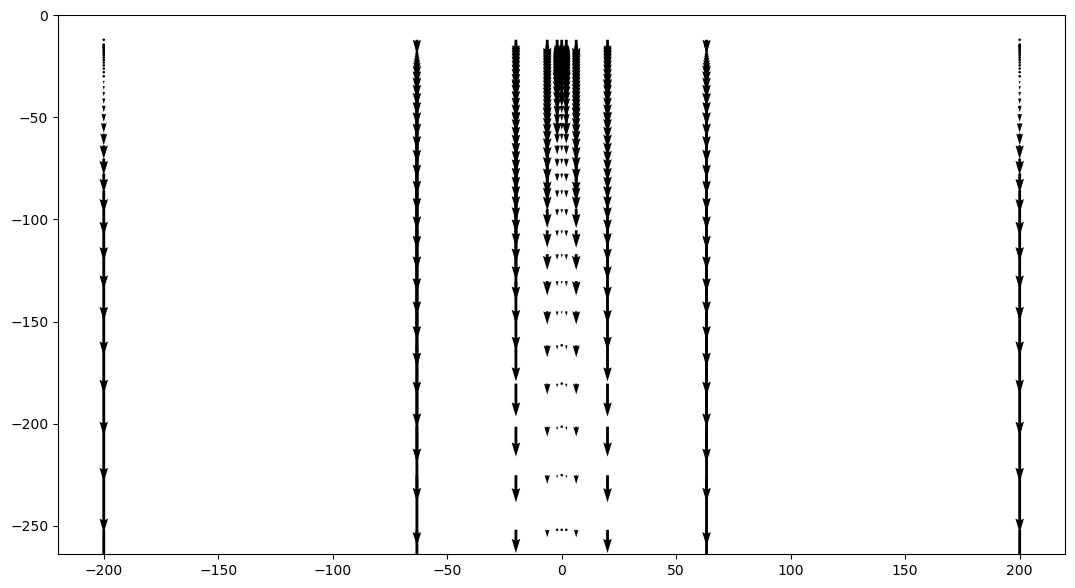

In [43]:
# %%
fig = plt.figure(figsize=(13, 7))
plt.quiver(a[:, 0].reshape(11, 11, 41)[5, :, :].ravel(),
           a[:, 2].reshape(11, 11, 41)[:, 5, :].ravel(),
           np.zeros(451),
           tz.reshape(11, 11, 41)[5, :, :].ravel()
           )
plt.show()

In [107]:
# Phase 2

In [44]:
import theano
import theano.tensor as T
import numpy as np
import sys

In [47]:
#densities = theano.shared(np.cast[dtype](np.zeros(3)), "List with the densities")
#tzz = theano.shared(np.cast[dtype](np.zeros((1, 3))), "Component z")
#select = theano.shared(np.cast['int8'](np.zeros(3)), "Select nearby cells")
    # Init gray voxels for gravity
#weigths_weigths = theano.shared(np.ones(0))
#weigths_index = theano.shared(np.ones(0, dtype='int32'))

In [79]:
density_block = np.array(list(data_frame['Density']))

In [80]:
density_block #= density_block.tolist()

array([0., 0., 0., ..., 0., 0., 0.])

### approach 1

In [129]:
select = theano.shared(np.cast['int8'](np.zeros(3)), "Select nearby cells")

n_measurements = tz.shape[0]

densities_rep = T.tile(density_block, n_measurements)

# what is 'self.select' see line 216 in theano_graph
densities_selected = densities_rep[T.nonzero(T.cast(select, "int8"))[0]]
densities_selected_reshaped = densities_selected.reshape((n_measurements, -1))

grav = densities_selected_reshaped * tz

k = grav.sum(axis=1)

In [47]:
#densities = theano.shared(np.cast[dtype](np.zeros(3)), "List with the densities")
#tzz = theano.shared(np.cast[dtype](np.zeros((1, 3))), "Component z")
#select = theano.shared(np.cast['int8'](np.zeros(3)), "Select nearby cells")
    # Init gray voxels for gravity
#weigths_weigths = theano.shared(np.ones(0))
#weigths_index = theano.shared(np.ones(0, dtype='int32'))

In [79]:
density_block = np.array(list(data_frame['Density']))

In [80]:
density_block #= density_block.tolist()

array([0., 0., 0., ..., 0., 0., 0.])

In [1]:
k

NameError: name 'k' is not defined

### approach 2

In [1]:
n_devices = T.cast((density_block.shape[0] / tz.shape[0]), dtype='int32')

n_devices = theano.printing.Print('n_devices')(n_devices)

tz_rep = T.tile(tz, n_devices)

# density times the component z of gravity
grav = (density_block * tz_rep).reshape((n_devices, -1)).sum(axis=1)

grav

station_forw_grav = np.round(np.append(station_coordinates, grav, axis=1),4)

### Function for Permeability - Geophysical measurement as constraints using Myself

In [ ]:
# Function for Permebility
# For loop from the outside
def perm(grid):
    data_dist0 = []
    data_dist1 = []
    data_dist2 = []
    grid_ = []
    for grid_line in grid:
        df = pd.DataFrame({'orig_block':grid_line})
        #con0 = original_lith_block_df['orig_block'] == 0
        con1 = df['orig_block'] == 1
        indices_1 = original_lith_block_df.index[con1].tolist()
        
        sharp_point_i = [j for j,m in enumerate(grid_line) if j and m and not grid_line[j-1]]
        
        if len(sharp_point_i) != 0:
            sharp_irange = np.arange(0,sharp_point_i[0])
            
            first_range_i = sharp_irange[:len(sharp_irange)//2]
            if len(first_range) != 0:
                dist = #sample from normal
                for k in range(len(first_range_i)):
                    grid_line[first_range_i[k]] = dist[k]
                
            second_range_i = sharp_irange[len(second_range_i)//2:]
            if len(second_range_i) != 0:
                dist = #sample from normal
                for k in range(len(second_range_i)):
                    grid_line[second_range_i[k]] = dist[k]
   
        
        if grid_line[-1] == 0:
            sharp_point_d = [j for j,m in enumerate(i) if j and m and not i[j+1]]
            if len(sharp_point_d) != 0:
                sharp_irange = np.arange(sharp_point_i[0]+1, len(grid_line))
            
            first_range_d = sharp_irange[:len(sharp_irange)//2]
            if len(first_range_d) != 0:
                dist = #sample from normal
                for k in range(len(first_range_d)):
                    grid_line[first_range_d[k]] = dist[k]
                
            second_range_d = sharp_irange[len(second_range_d)//2:]
            if len(second_range_d) != 0:
                dist = #sample from normal
                for k in range(len(second_range_d)):
                    grid_line[second_range_d[k]] = dist[k]
        
        dist = # normal
        for k in range(len(indices_1)):
            grid_line[indices_1[k]] = dist[k]
            
            
        grid_.append(grid_line)
        
    return grid_

In [13]:
# Function for thickness

In [ ]:
lith_block_MCMC = data.gaussian_dist_MCMC(400, 400, density) # all accepted grid / lith block

<img src="py_gaussian.gif" width="550" height="650" align="center">